In [1]:
# All the necessary imports
import pandas as pd
import numpy as np
import re
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

### Remark: For a smooth code execution, it is recommended to download all the excel files required in a folder named "Dataset_Needed" and the folder should be in the same directory as this jupyter notebook file, otherwise it will be necessary to change the paths name during the execution.

## Dataset: Companies names per sector

In [2]:
# Function that will help us retrieve all the companies names from our dataset
def get_companies(data):
    df = pd.DataFrame(data, columns= ['company'])
    companies = df.to_numpy().flatten()
    companies = list(dict.fromkeys(companies))
    return companies

In [3]:
# We get the data from our excel files
data_tech = pd.read_excel(r'Dataset_Needed\tech.xlsx')
data_automobile = pd.read_excel(r'Dataset_Needed\automobile.xlsx')
data_fashion = pd.read_excel(r'Dataset_Needed\fashion.xlsx')
data_finance = pd.read_excel(r'Dataset_Needed\finance.xlsx')

In [4]:
# We store all our companies names in arrays
companies_tech = get_companies(data_tech)
companies_automobile = get_companies(data_automobile)
companies_fashion = get_companies(data_fashion)
companies_finance = get_companies(data_finance)

In [5]:
# We print the companies names we have in our dataset per sector
print(companies_tech)
print(companies_automobile)
print(companies_fashion)
print(companies_finance)

['Adobe', 'AMD', 'Alibaba', 'Amazon', 'Apple', 'Cisco', 'Facebook', 'HP', 'IBM', 'Intel', 'Microsoft', 'Netflix', 'NVIDIA', 'Salesforce', 'SAP', 'Spotify', 'Tencent', 'Twitter', 'Samsung', 'Qualcomm', 'Broadcom', 'Texas', 'Google', 'Oracle', 'Sony', 'TSMC']
['Audi', 'BMW', 'Daimler', 'Ford', 'GM', 'Honda', 'Hyundai', 'Nissan', 'Renault', 'Tesla', 'Toyota', 'Volkswagen', 'Kia', 'Stellantis', 'Geely', 'Harley Da']
['Nike', 'Adidas', 'Lululemon', 'Under Armour', 'H&M', 'LVMH', 'Inditex', 'TJX Cos', 'L Brands', 'Anta Sports', 'VF Corp', 'Kering', 'Richemont', 'Fast Retailing', 'Burberry']
['Allianz', 'Amex', 'AIG', 'AXA', 'Bank of America', 'Capital One', 'Credit Suisse', 'Discover Financials', 'ING', 'Mastercard', 'UBS', 'Visa', 'Wells Fargo', 'JP Morgan', 'Goldman Sachs', 'Goldman Sa', 'DBS', 'Square', 'Paypal', 'Citi Group', 'HSBC', 'Ping An']


## Dataset: News coefficients per company

In [6]:
# Useful method to get the dates of the news
def clean(date):
    date = re.sub('[^0-9-]+', '', date)
    return datetime.strptime(date, '%Y-%m-%d')
# Useful method to get an aggregate of the different news values 
def get_cumul(date):
    df_date = df_news[df_news['date'] < date]
    array = df_date['flair polarity'].values
    sum = np.sum(array)
    avg = sum / len(array)
    return avg

In [7]:
# Importing the news
df_news = pd.read_excel(r'Dataset_Needed\sentiment_analysis.xlsx')
df_news['flair polarity'] = df_news.apply(lambda row: (row['flair confidence']*-1
                                                        if row['flair sentiment'] == 'NEGATIVE'
                                                        else row['flair confidence']), axis=1)
df_news = df_news[['date', 'company', 'flair polarity']]
df_news['date'] = df_news['date'].apply(clean)
df_news = df_news[df_news['date'] > datetime(2010, 12, 31)].sort_values(by='date', ascending=False)

## Stock prediction: using our sentiment coefficients to predict the closing prices

In [8]:
# Read all the stocks we have obtained from yahoo finance and import them in our data frame
df = pd.read_excel(r'Dataset_Needed\stocks_all_78.xlsx')
df = df[df['Date'] > datetime(2010, 12, 31)].sort_values(by='Date', ascending=False)

In [9]:
# This is the company's name, for this example we will use Adobe
company_name = 'Adobe'

# We get the stocks and news about that company
df = df[df['company_name'] == company_name]
df_news = df_news[df_news['company'] == company_name]

In [10]:
# Get the sentiment coefficient of the news and add it to our data frame
df['cumulative polarity'] = df['Date'].apply(get_cumul)
df = df.fillna(0)
df = df.set_index('Date').drop(columns=['company_name'])

In [11]:
# Create a new dataframe with only the Closing values and the sentiment coefficients 
data = df.filter(['Close', 'cumulative polarity'])
data = data.iloc[::-1]

# Convert the dataframe to a numpy array
dataset = data.values

In [12]:
# We will obtain the training data which will represent 95% of our data
training_data_len = int(np.ceil( len(dataset) * .95 ))

# We scale our data to the range (0,1) as it will make our RNN model more efficient
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Finally we get our training data
train_data = scaled_data[0:int(training_data_len), :]

In [13]:
# Our model will take 2 parameters as inputs and outputs who are as mentioned: Closing price & sentiment coefficient
input_dim = 2
output_dim = 2

In [14]:
# Now our goal is to obtain the x's and y's of our training data
x_train = []
y_train = []

# The look_back value will be used in the stock prediction, we set it by default to 60
look_back = 60
for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i])
    y_train.append(train_data[i])  
    
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to (x_train.shape[0], x_train.shape[0], output_dim)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], output_dim))

In [15]:
# In this part, we will set our RNN model with the following parameters
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], input_dim)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(output_dim))

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2332/2332 [==============================] - 24s 10ms/step - loss: 0.0019


In [17]:
# Now we create the testing data similarly to the training data but with the remaining 5% of our data
test_data = scaled_data[training_data_len - look_back: , :]

# Now our goal is to obtain the x's and y's of our testing data
x_test = []
y_test = dataset[int(training_data_len):, :]
for i in range(look_back, len(test_data)):
    x_test.append(test_data[i-look_back:i])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], output_dim ))

In [18]:
# Now we test our model by making predictions on the testing data and outputting the MAPE value
y_test = y_test[:,0]
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:,0]
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(mape, ' %')

7.066822287850181  %


## Visualization: How accurate was our prediction

In [19]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-19-c6cb20b0ec05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


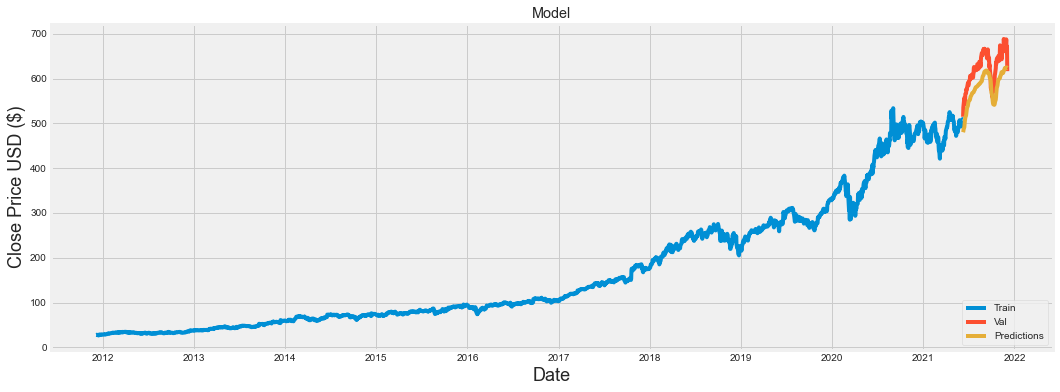

In [20]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# We can have a look at the real close values vs the predicted ones
valid

,Close,cumulative polarity,Predictions
Date,,,
2021-06-09,514.679993,-0.348887,480.195099
2021-06-10,535.520020,-0.348887,482.214539
2021-06-11,541.260010,-0.348887,486.330505
2021-06-14,556.950012,-0.348887,491.607300
2021-06-15,548.460022,-0.348887,498.459930
...,...,...,...
2021-11-29,687.489990,-0.348887,623.142273
2021-11-30,669.849976,-0.348887,624.469299
2021-12-01,657.409973,-0.348887,624.881287
